# Computational Methods for Astrophysics, Homework #5, Askold Vilkha, Taylor Paul, Clive Binu

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
import chebyshev as cheby
from scipy import linalg

## Exercise 1, Solving Boundary Value Problem using Chebyshev polynomials

For this exercise, we will solve the following Boundary Value Problem (BVP)
 
\begin{split}
  \frac{d^2 \psi}{dr^2} + \frac{2}{r} \frac{d \psi}{dr} + 4\pi \rho(r) = 0, \quad 0 < r < r_{\rm max}\\
  \frac{d \psi} {dr} = 0,\\
  r_{\rm max} \frac{d \psi}{dr} + \psi(r_{\rm max}) = 0,\\
  \rho(r) = \left\{\begin{array}{lr} 1 & 0 \leq r \leq 1 \\
                                      e^{-r+1} & r \geq 1 \end{array}\right.\\
\end{split}
                                  
For simplicity, we can replace the $\psi(r)$ with $y(r)$:

\begin{split}
  y''(r) + \frac{2}{r} y'(r) = - 4\pi \rho, \quad 0 < r < r_{\rm max},\\
  y'(0) = 0,\\
  r_{\rm max} y'(r_{\rm max}) + y(r_{\rm max}) = 0
\end{split}

 
Here, we will use Chebyshev polynomials to approximate $y$.
$$ y(r) \approx \sum_{n=0}^{n_{\rm max}} c_n T_n(x(r)), $$
where 
$$x(r) = -1 + 2\left(  \frac{r-0}{r_{\rm max} - 0}\right)  $$
Therefore:
$$
x(0) = -1, \quad x(r_{\rm max}) = 1$$
Hence:
$$dx/dr = 2 / r_{\rm max}$$
 
We'll solve the above equations for Chebyshev coefficients $c_n$ on Gauss-Lobatto grid with $n_{\rm max} + 1$ points, the first and the last of these being the two end points of the domain.

$$ y'(0) = 0 \to  \sum_{n=0}^{n_{\rm max}} c_n T'_n(-1) dx/dr = 0,$$ 

$$ r_{\rm max} y'(r_{\rm max}) + y(r_{\rm max}) = 0  \to 
\sum_{n=0}^{n_{\rm max}} c_n \left[r_{\rm max} T'_n(1) dx/dr + T_n(1)\right] = 0$$ 


$$ \sum_{n=0}^{n_{\rm max}} c_n(T''(x_i) (dx/dr)^2 + \frac{2}{r_i} (dx/dr) T'(x_i) ) = - 4 \pi \rho(r_i), \quad i= 1\cdots n_{\rm max} - 1
$$

All of these are equivalent to matrix equations of the form
$$
{\bf J}{\bf C} = {\bf S},
$$
where ${\bf C} = (c_0, c_1, \cdots)^T$, and this matrix represents the Chebyshev coefficients. Matrix ${\bf J}$ is the Jacobian matrix, and ${\bf S}$ is the source term, or RHS of the equations above.
Hence ${\bf C} = {\bf J}^{-1} {\bf S}$. 

The first domain we will consider is a single subdomain $[0, r_{\rm max}]$.

In our code, `rho_func` is used to calculate the density $\rho(r)$, and `x_and_r_func` converts $x$ to $r$ and vice versa. The function `Chebyshev_ODE_solver` solves the above equations and uses the Chebyshev coefficients obtained to solve the ODE defined above. 

In [2]:
def rho_func(r: np.ndarray, r_in: float = 0, r_out: float = 10):
    '''
    Function to calculate the density function rho(r) for a given r

    Parameters
    ----------
    r : np.ndarray
        Array of r values
    r_in : float, optional
        Inner radius, by default 0
    r_out : float, optional
        Outer radius, by default 10
    
    Returns
    -------
    rho_val : np.ndarray
        Array of rho values
    
    Raises
    ------
    ValueError
        If r contains negative values
    '''

    if np.min(r) < r_in or np.max(r) > r_out:
        raise ValueError('r must be in the interval [r_in, r_out]')

    rho_val = np.where(r <= 1, 1, np.exp(-r + 1))

    return rho_val

In [3]:
def x_and_r_func(r: float = None, x: float = None, r_in: float = 0, r_out: float = 10):
    '''
    Function to calculate the x(r) or r(x), and dx/dr for a given r or x. Either r or x must be specified. If r is provided, x is calculated, and vice versa.

    Parameters
    ----------
    r : float, optional
        Radius, by default None
    x : float, optional
        x, by default None
    r_in : float, optional
        Inner radius, by default 0
    r_out : float, optional
        Outer radius, by default 10
    
    Returns
    -------
    x_of_r : float
        x value for a given r
    r_of_x : float
        r value for a given x
    dx_over_dr : float
        dx/dr for a given r
    
    Raises
    ------
    ValueError
        If r is not between r_in and r_out
    ValueError
        If both r and x are specified or None of them are specified

    '''

    if np.all(r) != None:
        if np.any(r < r_in) or np.any(r > r_out):
            raise ValueError('r must be between r_in and r_out')
    
    if (r is None) == (x is None):
        raise ValueError('Either r or x must be specified')
    
    dx_over_dr = 2 / (r_out - r_in)

    if r is None:
        r_of_x = r_in + (r_out - r_in) * (x + 1) / 2
        return r_of_x, dx_over_dr
    else:
        x_of_r = -1 + 2 * (r - r_in) / (r_out - r_in)
        return x_of_r, dx_over_dr

In [4]:
def Chebyshev_ODE_solver(Nmax: int, r_in: float = 0, r_out: float = 10):
    '''
    This function solves the ODE defined in the beginning of this problem using Chebyshev collocation method. 
    If one needs needs to solve the ODE for a different rho(r), x(r) or r(x), then the functions rho_func and x_and_r_func must be modified accordingly. 
    The same applies for the source term, but it should be modified inside the function.

    Parameters
    ----------
    Nmax : int
        Maximum order of Chebyshev polynomial. Must be greater than 0
    r_in : float, optional
        Inner radius, by default 0
    r_out : float, optional
        Outer radius, by default 10
    
    Returns
    -------
    test_grid : np.ndarray
        Array of r values on which the solution is reconstructed
    solution : np.ndarray
        Array of solution values on the test grid
    resid : np.ndarray
        Array of residuals on the test grid
    
    Raises
    ------
    ValueError
        If `r_in >= r_out`
    ValueError
        If `Nmax < 1`
    '''
    if r_in >= r_out:
        raise ValueError('r_in must be less than r_out')
    if Nmax < 1:
        raise ValueError('Nmax must be greater than 0')
    
    # initialize grid
    x_grid = cheby.GaussLobattoGrid(Nmax)
    r_grid, dxdr = x_and_r_func(x = x_grid, r_in = r_in, r_out = r_out)
    J_matr = np.zeros((Nmax + 1, Nmax + 1))

    # first and last rows - boundary conditions
    # Note the n of Tn is equal to the column number
    for col in range(Nmax + 1):
        # r = r_in boundary condition
        J_matr[0, col] = dxdr * cheby.ChebyshevTx(col, -1)

        # outer BC
        J_matr[-1, col] = r_out * dxdr * cheby.ChebyshevTx(col, 1) + cheby.ChebyshevT(col, 1)
    
    # interior rows
    for row in range(1, Nmax):
        for col in range(Nmax + 1):
            J_matr[row, col] = (np.power(dxdr, 2) * cheby.ChebyshevTxx(col, x_grid[row]) + 2 / r_grid[row] * dxdr * cheby.ChebyshevTx(col, x_grid[row]))
    
    # source term 
    S_matr = -4 * np.pi * rho_func(r_grid,  r_in = r_in, r_out = r_out)  
    # source terms on the boundaries
    S_matr[0] = 0 
    S_matr[-1] = 0

    # solve the matrix equation and get the Chebyshev coefficients
    C_matr = linalg.solve(J_matr, S_matr)

    # reconstruct solution on a fine grid
    test_grid = np.linspace(r_in + 1.0e-4, r_out - 1.0e-4, 500)
    x_grid = x_and_r_func(r = test_grid, r_in = r_in, r_out = r_out)[0]

    solution = np.array([cheby.ReconT(C_matr, x) for x in x_grid])
    # y_p - first derivative, y_pp - second derivative
    y_p = np.array([cheby.ReconTx(C_matr, x) for x in x_grid]) * dxdr
    y_pp = np.array([cheby.ReconTxx(C_matr, x) for x in x_grid]) * np.power(dxdr, 2)

    resid = y_pp + 2 / test_grid * y_p + 4 * np.pi * rho_func(test_grid, r_in = r_in, r_out = r_out)

    return test_grid, solution, resid

In [5]:
test_grid, solution, resid = Chebyshev_ODE_solver(Nmax = 500, r_in = 0, r_out = 10)

The resulting numerical solution is shown in Fig. 1.

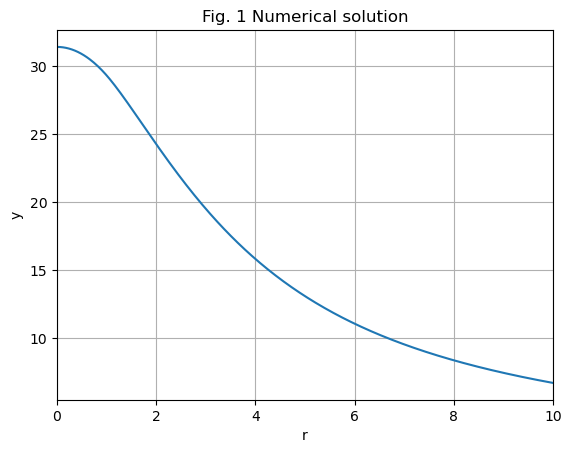

In [6]:
plt.plot(test_grid, solution)
plt.xlabel('r')
plt.ylabel('y')
plt.xlim(0, 10); plt.grid(True)
plt.title('Fig. 1 Numerical solution');

Now that we have solved the problem numerically, we can compare the numerical solution with the analytical solution. To obtain the analytical solution, we use the computer algebra package `sympy`. Note, that for the equation that we have, we need to use some "trickery". First of all, we are going to solve two differential equations, corresponding to the two subdomains, since they have different values of $\rho$ function.

In [7]:
# define the symbols
r_sym = Symbol('r')
y_sym = Function('y')
rho_func_sym = Function('rho')

# define the differential equation
eq = Eq(y_sym(r_sym).diff(r_sym).diff(r_sym) + 2 / r_sym * y_sym(r_sym).diff(r_sym) + 4 * pi * rho_func_sym(r_sym), 0)

# substitute rho with its definition
eq_1 = eq.subs(rho_func_sym(r_sym), 1) # the rho function at 0 < r < 1 
eq_2 = eq.subs(rho_func_sym(r_sym), exp(-r_sym + 1)) # the rho function at 1 < r < 10 

# define the boundary conditions
ics_1_sym = {y_sym(r_sym).diff(r_sym).subs(r_sym, 0): 0}

# solve the differential equation
sol_1 = dsolve(eq_1, ics = ics_1_sym)
sol_2 = dsolve(eq_2)

In [8]:
sol_1.rhs # solution for rho = 1

C1 - 2*pi*r**2/3

In [9]:
sol_2.rhs #solution for rho = exp(-r + 1)

C1 + C2/r - 4*pi*exp(1 - r) - 8*pi*exp(1 - r)/r

As we can see, these solution still have some unknown constants. That happens because our first initial condition ($y'(0) = 0$) can only be applied to the subdomain $r \in [0, 1]$, where $\rho(r) = 1$. Another initial condition ($r_{\rm max} y'(r_{\rm max}) + y(r_{\rm max}) = 0$) can only be applied to the subdomain $r \in [1, r_{\rm max}]$, where $\rho(r) = e^{-r + 1}$. We can use it to obtain constant $C_1$ for the `sol_2`. This is shown below.

In [10]:
(sol_2.rhs.diff(r_sym) * r_sym).subs(r_sym, 10) + sol_2.rhs.subs(r_sym, 10)

C1 + 44*pi*exp(-9)

Therefore, $C_1 = \frac{ - 44 \pi}{e^9}$ (for the 2nd solution). Now we can apply continuity condition to find $C_1$ for the first solution and $C_2$ for the second solution. This is shown below.

In [11]:
C1 = Symbol('C1')
C2 = Symbol('C2')
sol_2.rhs.subs({r_sym: 1, C1: - 44 * np.pi / np.power(np.e, 9)})  - sol_1.rhs.subs(r_sym, 1)

-C1 + C2 - 34*pi/3 - 0.0170589466915854

This has to be zero, thus we know the difference between $C_1$ (`sol_1`) and $C_2$ (`sol_2`). Even though we do not know specific value of $C_1$ and $C_2$, we can still try to choose them assuming that the function is continuous and does not have a peak at $r = 1$. This is shown below in Fig. 2. We have chosen $C_1 = 10 \pi$

In [12]:
sol_1_func = lambdify(r_sym, sol_1.rhs.subs(C1, 10 * np.pi))
sol_2_func = lambdify(r_sym, sol_2.rhs.subs({C1: - 44 * np.pi / np.power(np.e, 9), C2: 10 * np.pi + 34 /3 * np.pi + 44 * np.pi / np.power(np.e, 9)}))

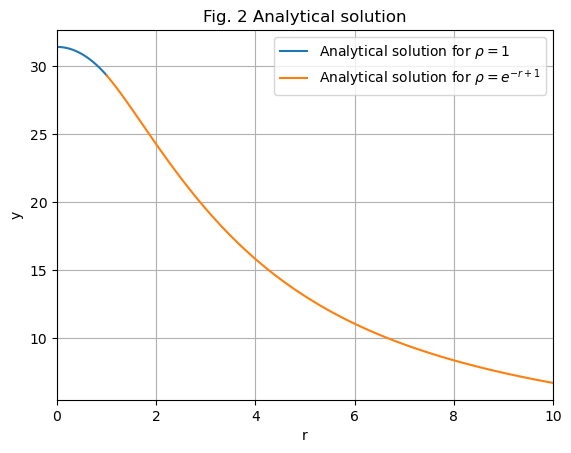

In [13]:
r_test_1 = np.linspace(0, 1, 100)
plt.plot(r_test_1,  sol_1_func(r_test_1), label = r'Analytical solution for $\rho = 1$')
r_test_2 = np.linspace(1, 10, 100)
plt.plot(r_test_2,  sol_2_func(r_test_2), label = r'Analytical solution for $\rho = e^{-r + 1}$')
plt.xlabel('r'); plt.ylabel('y')
plt.xlim(0, 10); plt.grid(True)
plt.legend()
plt.title('Fig. 2 Analytical solution');

Now we can compare the analytical solution and the numerical and plot the error. This is shown in Fig. 3. We also plot the residual of the numerical solution to see how well the algorithm predicts its own error.

In [14]:
def analytic_func(r: np.ndarray, r_in: float = 0, r_out: float = 10):
    '''
    Function to calculate the analytic solution for a given r

    Parameters
    ----------
    r : np.ndarray
        Array of r values
    r_in : float, optional
        Inner radius, by default 0
    r_out : float, optional
        Outer radius, by default 10
    
    Returns
    -------
    analytic_sol : np.ndarray
        Array of analytic solution values
    
    Raises
    ------
    ValueError
        If r contains negative values
    '''

    if np.min(r) < r_in or np.max(r) > r_out:
        raise ValueError('r must be in the interval [r_in, r_out]')

    analytic_sol = np.where(r <= 1, sol_1_func(r), sol_2_func(r))

    return analytic_sol

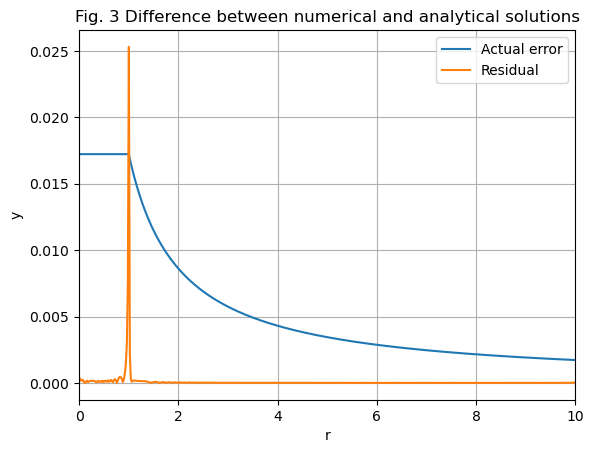

In [15]:
plt.plot(test_grid, np.abs(solution - analytic_func(test_grid)), label = r'Actual error')
plt.plot(test_grid, np.abs(resid), label = r'Residual')
plt.xlabel('r'); plt.ylabel('y')
plt.xlim(0, 10); plt.grid(True)
plt.legend()
plt.title('Fig. 3 Difference between numerical and analytical solutions');

In [16]:
L_inf_test = np.max(np.abs(solution - analytic_func(test_grid)))
print(r'L_inf norm of the error is %g'%L_inf_test)

L_inf norm of the error is 0.0172305


As we can see, the error is the largest approximately where the function values are large, i. e. before reaching $r = 1$, where $\rho = 1$. Also the error significantly decreases for the 2nd part of the function, where $\rho = e^{-r + 1}$.

Now we can see how the $L_{\infty}$ norm of the error changes with the number of points. This is shown in Fig. 4.

In [17]:
N_points_test = np.arange(100, 1001, 100)
L_inf_single_test = np.zeros(len(N_points_test))
L_inf_resid_single_test = np.zeros(len(N_points_test))
for i in range(len(N_points_test)):
    test_grid, solution, resid = Chebyshev_ODE_solver(N_points_test[i])
    L_inf_single_test[i] = np.max(np.abs(solution - analytic_func(test_grid)))
    L_inf_resid_single_test[i] = np.max(np.abs(resid))

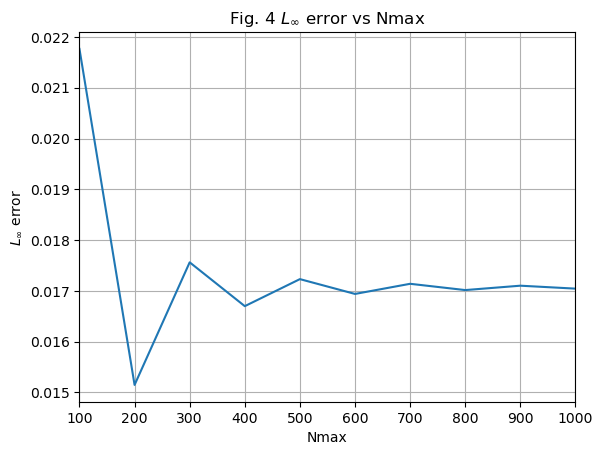

In [18]:
plt.plot(N_points_test, L_inf_single_test)
plt.xlabel('Nmax'); plt.ylabel(r'$L_{\infty}$ error')
plt.xlim(100, 1000)
plt.xticks(N_points_test); plt.grid(True)
plt.title('Fig. 4 $L_{\infty}$ error vs Nmax');

As we can see, the $L_{\infty}$ norm of the error decreases to some extent and then oscillates around $0.017$. Logically, the error decreases with increasing number of points, however, the minimal error is encountered at 200 points. We can also check how the maximum value of the residual, i. e. $L_{\infty}$ norm of the local error changes with the number of points. This is shown in Fig. 5.

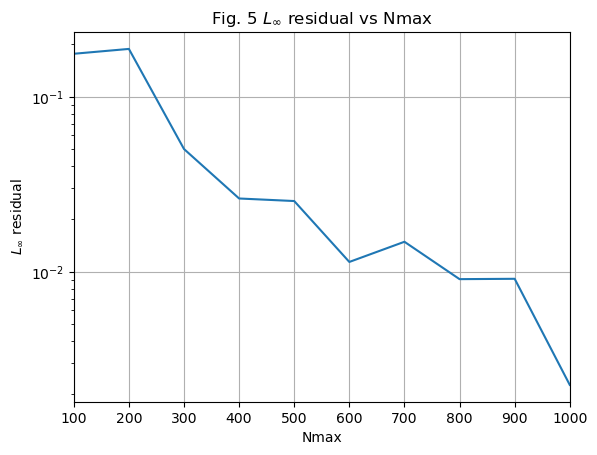

In [19]:
plt.plot(N_points_test, L_inf_resid_single_test)
plt.xlabel('Nmax'); plt.ylabel(r'$L_{\infty}$ residual')
plt.xlim(100, 1000)
plt.yscale('log')
plt.xticks(N_points_test); plt.grid(True)
plt.title('Fig. 5 $L_{\infty}$ residual vs Nmax');

Here we can see more typical behavior for the error, the maximum value of the residual decreases with increasing number of points. Also, the largest error is estimated at 200 points, which is coincident with the smallest $L_{\infty}$ norm of the error if we compare with the analytic solution. This could happen because at 200 points the grid encounters some problematic value, which causes the algorithm to show larger local error. 

Now, we want to separate our grid into two domains, where the first one is $r \in [0, 1]$ and the second one is $r \in [1, r_{\rm max}]$.  We will refer to these as the `left` and `right` domains. 

On the `left` domain, we have
$$ y_L(r) \approx \sum_{n=0}^{n_{\rm L max}} c_n T_n(x_L(r)) $$
and on the `right` domain we have
$$ y_R(r) \approx \sum_{n=0}^{n_{\rm R max}} d_n T_n(x_R(r)) $$

Here $x_L(r)$ maps $[0,1]$ to $[-1,1]$ and
$x_R(r)$ maps $[1,r_{\rm max}]$ to $[-1,1]$.

The resulting algebraic equations are the following.
These represent the boundary conditions:
$$ y'(0) = 0 \to  \sum_{n=0}^{n_{\rm L max}} c_n T'_n(-1) \frac{dx_L}{dr} = 0,$$ 

 $$ r_{\rm max} y'(r_{\rm max}) + y(r_{\rm max}) = 0  \to 
\sum_{n=0}^{n_{\rm R max}} d_n \left[r_{\rm max} T'_n(1) \frac{dx_R}{dr} + T_n(1)\right] = 0$$ 
These represent the continuity conditions:
$$ y_L(r_s) = y_R(r_s) \to  \sum_{n=0}^{n_{\rm L max}} c_n T_n(1) -  \sum_{n=0}^{n_{\rm R max}} d_n T_n(-1) =  0 $$
$$ y_L'(r_s) = y_R'(r_s) \to  \sum_{n=0}^{n_{\rm L max}} c_n \frac{dx_L}{dr} T'_n(1) -  \sum_{n=0}^{n_{\rm R max}} d_n \frac{d x_R}{dr} T'_n(-1) =  0 $$
These represent the rest of the grid:
$$ \sum_{n=0}^{n_{\rm L max}} c_n\left[T_n''(x_i) (\frac{dx_L}{dr})^2 + \frac{2}{r_L(x_i)} (\frac{dx_L}{dr}) T_n'(x_i) \right] = - 4 \pi \rho(r_L(x_i)), \quad i= 1\cdots n_{\rm L max} - 1 $$

$$ \sum_{n=0}^{n_{\rm R max}} d_n\left[T_n''(x_i) (\frac{dx_R}{dr})^2 + \frac{2}{r_R(x_i)} (\frac{dx_R}{dr}) T_n'(x_i) \right] = - 4 \pi \rho(r_R(x_i)), \quad i= 1\cdots n_{\rm R max} - 1 $$

These equations can be written in the form
${\bf J}{\bf C} = {\bf S}$, where ${\bf J}$ is a block diagonal matrix, ${\bf C}$ is the vector $(c_0, c_1,\cdots, c_{nmaxL}, d_0, d_1, \cdots, d_{nmaxR})$

The function `Chebyshev_ODE_solver_2domain` solves the above equations and uses the Chebyshev coefficients obtained to solve the ODE defined above.

In [20]:
def Chebyshev_ODE_solver_2domain(Nmax1: int, Nmax2: int = None, r_in: float = 0, r_s: float = 1, r_out: float = 10):
    '''
    This function solves the ODE defined above using Chebyshev collocation method. 
    The solution is similar to the one in `Chebyshev_ODE_solver`, but the domain is split into two parts: 0 < r < r_s and r_s < r < r_out.
    That requires additional continuity conditions at r = r_s, which are implemented in this function.

    Parameters
    ----------
    Nmax1 : int
        Maximum order of Chebyshev polynomial for the first domain. Must be greater than 0
    Nmax2 : int, optional
        Maximum order of Chebyshev polynomial for the second domain. Must be greater than 0. If None, then Nmax2 = Nmax1
    r_in : float, optional
        Inner radius, by default 0
    r_s : float, optional
        Radius at which the domain is split, by default 1
    r_out : float, optional
        Outer radius, by default 10
    
    Returns
    -------
    test_grid : np.ndarray
        Array of r values on which the solution is reconstructed
    solution : np.ndarray
        Array of solution values on the test grid
    resid : np.ndarray
        Array of residuals on the test grid
    
    Raises
    ------
    ValueError
        If `r_in >= r_s` or `r_s >= r_out` or `r_in >= r_out`
    ValueError
        If `Nmax1 < 1` or `Nmax2 < 1`
    '''
    if Nmax2 is None:
        Nmax2 = Nmax1
    if r_in >= r_s or r_s >= r_out or r_in >= r_out:
        raise ValueError('r_in must be less than r_s and r_s must be less than r_out')
    if Nmax1 < 1 or Nmax2 < 1:
        raise ValueError('Nmax1 and Nmax2 must be greater than 0')

    # initialize grid 
    x_grid_1 = cheby.GaussLobattoGrid(Nmax1)
    x_grid_2 = cheby.GaussLobattoGrid(Nmax2)
    r_grid_1, dxdr1 = x_and_r_func(x = x_grid_1, r_in = r_in, r_out = r_s)
    r_grid_2, dxdr2 = x_and_r_func(x = x_grid_2, r_in = r_s, r_out = r_out)
    r_grid = np.concatenate((r_grid_1, r_grid_2))

    N_coll_1 = Nmax1 + 1
    N_coll_2 = Nmax2 + 1
    N_coll_tot = N_coll_1 + N_coll_2
    J_matr = np.zeros((N_coll_tot, N_coll_tot))

    # boundary conditions for the first domain
    for col in range(N_coll_1):
        # r = r_in boundary condition
        J_matr[0, col] = dxdr1 * cheby.ChebyshevTx(col, -1)
        # continuity conditions
        J_matr[N_coll_1 - 1, col] = cheby.ChebyshevT(col, 1)
        J_matr[N_coll_1, col] = dxdr1 * cheby.ChebyshevTx(col, 1) # derivative

    # boundary conditions for the second domain
    for j in range(N_coll_2):
        col = j + N_coll_1
        # continuity conditions
        J_matr[N_coll_1 - 1, col] = -cheby.ChebyshevT(j, -1)
        J_matr[N_coll_1, col] = -dxdr2 * cheby.ChebyshevTx(j, -1) # derivative
        # r = r_out boundary condition
        J_matr[-1, col] = r_out * dxdr2 * cheby.ChebyshevTx(j, 1) + cheby.ChebyshevT(j, 1)

    # filling the interior rows of J_matr
    # first domain
    for row in range(1, N_coll_1 - 1):
        for col in range(N_coll_1):
            J_matr[row, col] = (np.power(dxdr1, 2) * cheby.ChebyshevTxx(col, x_grid_1[row]) + 2 / r_grid_1[row] * dxdr1 * cheby.ChebyshevTx(col, x_grid_1[row]))
    # second domain
    for i in range(1, N_coll_2 - 1):
        for j in range(N_coll_2):
            row = i + N_coll_1
            col = j + N_coll_1
            J_matr[row, col] = (np.power(dxdr2, 2) * cheby.ChebyshevTxx(j, x_grid_2[i]) + 2 / r_grid_2[i] * dxdr2 * cheby.ChebyshevTx(j, x_grid_2[i]))

    # source term
    S_matr = -4 * np.pi * rho_func(r_grid, r_in = r_in, r_out = r_out)
    # source terms on the boundaries
    S_matr[0] = 0
    S_matr[-1] = 0
    # source terms for the continuity conditions
    S_matr[N_coll_1 - 1] = 0
    S_matr[N_coll_1] = 0
    
    # solve the matrix equation and get the Chebyshev coefficients
    C_matr = linalg.solve(J_matr, S_matr)

    # reconstruct solution on a fine grid
    test_grid_1 = np.linspace(r_in + 1.0e-4, r_s - 1.0e-4, 500)
    test_grid_2 = np.linspace(r_s + 1.0e-4, r_out - 1.0e-4, 500)
    test_grid = np.concatenate((test_grid_1, test_grid_2))
    x_grid_1 = x_and_r_func(r = test_grid_1, r_in = r_in, r_out = r_s)[0]
    x_grid_2 = x_and_r_func(r = test_grid_2, r_in = r_s, r_out = r_out)[0]

    solution_1 = np.array([cheby.ReconT(C_matr[:N_coll_1], x) for x in x_grid_1])
    solution_2 = np.array([cheby.ReconT(C_matr[N_coll_1:], x) for x in x_grid_2])
    solution = np.concatenate((solution_1, solution_2))

    # y_p - first derivative
    y_p_1 = np.array([cheby.ReconTx(C_matr[:N_coll_1], x) for x in x_grid_1]) * dxdr1
    y_p_2 = np.array([cheby.ReconTx(C_matr[N_coll_1:], x) for x in x_grid_2]) * dxdr2
    y_p = np.concatenate((y_p_1, y_p_2))
    # y_pp - second derivative
    y_pp_1 = np.array([cheby.ReconTxx(C_matr[:N_coll_1], x) for x in x_grid_1]) * np.power(dxdr1, 2)
    y_pp_2 = np.array([cheby.ReconTxx(C_matr[N_coll_1:], x) for x in x_grid_2]) * np.power(dxdr2, 2)
    y_pp = np.concatenate((y_pp_1, y_pp_2))

    resid = y_pp + 2 / test_grid * y_p + 4 * np.pi * rho_func(test_grid, r_in = r_in, r_out = r_out)

    return test_grid, solution, resid

Just to verify that this function works correctly, we can plot the solution for the same number of points as in the previous case. This is shown in Fig. 6.

In [21]:
test_grid_2dom, solution_2dom, resid_2dom = Chebyshev_ODE_solver_2domain(Nmax1 = 500, r_in = 0, r_s = 1, r_out = 10)

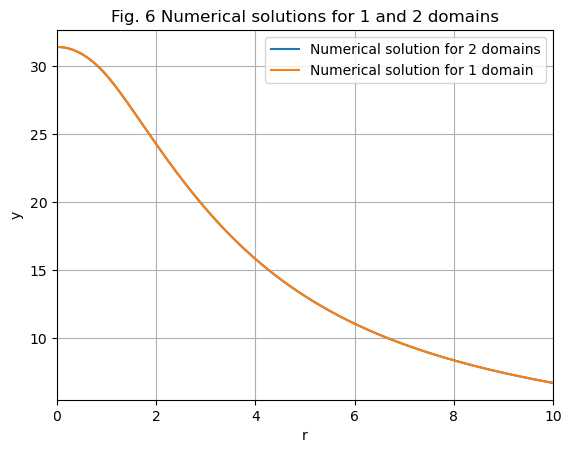

In [22]:
plt.plot(test_grid_2dom, solution_2dom, label = 'Numerical solution for 2 domains')
plt.plot(test_grid, solution, label = 'Numerical solution for 1 domain')
plt.xlabel('r'); plt.ylabel('y')
plt.xlim(0, 10); plt.grid(True)
plt.legend()
plt.title('Fig. 6 Numerical solutions for 1 and 2 domains'); 

As we can see, the lines on the plot coincide so the solutions are practically the same. Now, we can compare the numerical solution with the analytical solution and plot the $L_{\infty}$ norm of the error like we did for a single domain method. The results are shown in Fig. 7 and Fig. 8.

In [23]:
L_inf_2dom_test = np.zeros(len(N_points_test))
L_inf_resid_2dom_test = np.zeros(len(N_points_test))
for i in range(len(N_points_test)):
    test_grid_2dom, solution_2dom, resid_2dom = Chebyshev_ODE_solver_2domain(Nmax1 = N_points_test[i], r_in = 0, r_s = 1, r_out = 10)
    L_inf_2dom_test[i] = np.max(np.abs(solution_2dom - analytic_func(test_grid_2dom)))
    L_inf_resid_2dom_test[i] = np.max(np.abs(resid_2dom))

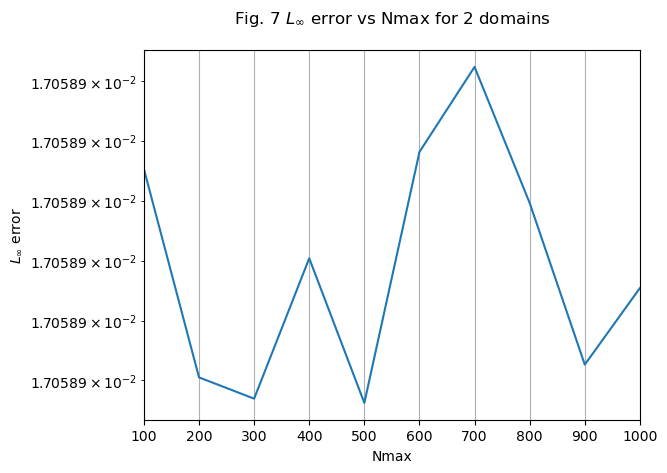

In [24]:
plt.plot(N_points_test, L_inf_2dom_test)
plt.xlabel('Nmax'); plt.ylabel(r'$L_{\infty}$ error')
plt.xlim(100, 1000)
plt.xticks(N_points_test); plt.grid(True)
plt.yscale('log')
plt.title('Fig. 7 $L_{\infty}$ error vs Nmax for 2 domains', y = 1.05);

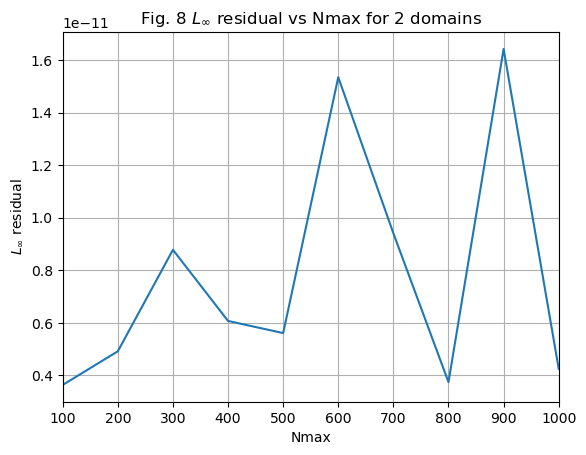

In [25]:
plt.plot(N_points_test, L_inf_resid_2dom_test)
plt.xlabel('Nmax'); plt.ylabel(r'$L_{\infty}$ residual')
plt.xlim(100, 1000)
plt.xticks(N_points_test); plt.grid(True)
plt.title('Fig. 8 $L_{\infty}$ residual vs Nmax for 2 domains');

As we can see, the $L_{\infty}$ norm of the error is $\sim 0.017$ for the 2 domain method even at 100 points, so it reaches its best accuracy much faster than the single domain method. Also, the oscillation of the $L_{\infty}$ norm of the error for this method is much smaller. The local error (residual) is significantly smaller for the 2 domain method, however it is the smallest at 100 points. Our guess is that with more points, the algorithm might reach some problematic points. Sometimes the residual decreases, for example at $800$ points, sometimes it peaks, for example at $600$ and $900$ points. Also, given that the $L_{\infty}$ norm of the error is approximately the same for any number of points, and the residual is of the order $10^{-11}$, these changes do not seem to be significant.